# Buy/Short-on-Gap Strategy

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
DOWdf = pd.read_csv('data/DOW_hourly_history.csv', header=0)
DOWdf['Date'] = pd.to_datetime(DOWdf['Date'], errors='coerce')
DOWdf.set_index('Date', inplace=True)

## Calculations & Buy-on-Gap Strategy

In [3]:
stocks = ['DIA','GS.N','NKE.N','CSCO.OQ','JPM.N','DIS.N','INTC.OQ','DOW.N','MRK.N','CVX.N','AXP.N','VZ.N','HD.N','WBA.OQ','MCD.N','UNH.N','KO.N','JNJ.N','MSFT.OQ','HON.OQ','CRM.N','PG.N','IBM.N','MMM.N','AAPL.OQ','WMT.N','CAT.N','AMGN.OQ','V.N','TRV.N','BA.N']

daily_first_hour = DOWdf.groupby(DOWdf.index.date).first()
daily_last_hour = DOWdf.groupby(DOWdf.index.date).last()

portfolio = pd.DataFrame(index=daily_first_hour.index, columns=stocks)
portfolio_returns = pd.DataFrame(index=daily_first_hour.index, columns=stocks)

for stock in stocks:
    daily_first_hour[f'{stock}_PrevLow'] = daily_first_hour[stock].shift(1)

    daily_first_hour[f'{stock}_GapReturn'] = (daily_first_hour[stock] - daily_first_hour[f'{stock}_PrevLow']) / daily_first_hour[f'{stock}_PrevLow']

    std_dev = daily_first_hour[f'{stock}_GapReturn'].rolling(window=90).std()

    gapped_down = daily_first_hour[f'{stock}_GapReturn'] < -std_dev
    
    daily_first_hour[f'{stock}_20D_MA'] = daily_first_hour[stock].rolling(window=20).mean()

    above_MA = daily_first_hour[stock] > daily_first_hour[f'{stock}_20D_MA']

    buy_decision = gapped_down & above_MA
    portfolio[stock] = buy_decision.astype(int)

    portfolio_returns[stock] = portfolio[stock] * (daily_last_hour[stock] - daily_first_hour[stock]) / daily_first_hour[stock]

portfolio_returns['Total_Return'] = portfolio_returns.sum(axis=1)


## Buy-on-Gap Cumulative Returns Visualization + Statistics

APR: 190.50%
Sharpe Ratio: 3.05


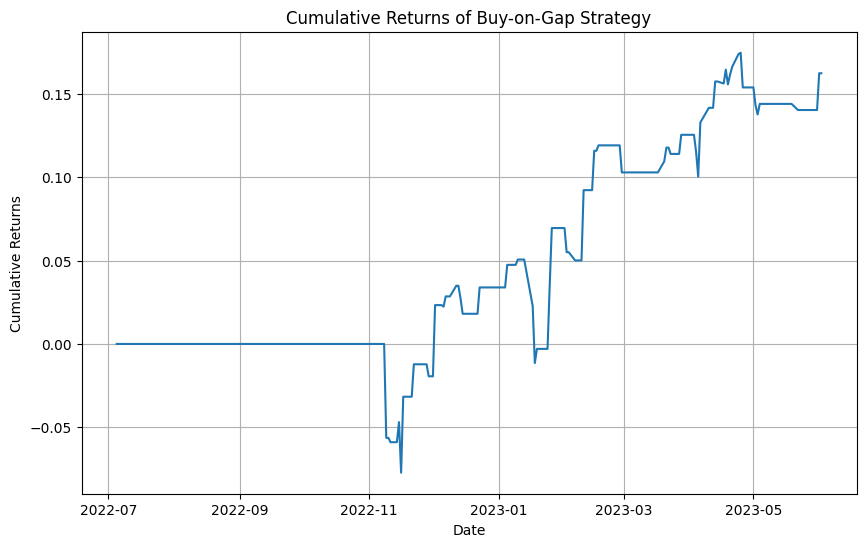

In [4]:
portfolio_returns['Cumulative_Return'] = portfolio_returns['Total_Return'].cumsum()

# APR
trading_periods = len(portfolio_returns)
years = trading_periods / 1638  
APR = (portfolio_returns['Cumulative_Return'].iloc[-1] + 1) ** (1/years) - 1

# Sharpe
mean_daily_return = portfolio_returns['Total_Return'].mean()
std_dev_return = portfolio_returns['Total_Return'].std()
sharpe_ratio = np.sqrt(1638) * (mean_daily_return / std_dev_return)

print(f"APR: {APR*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

portfolio_returns['Cumulative_Return'].plot(figsize=(10, 6), title="Cumulative Returns of Buy-on-Gap Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()

## Calculations & Short-on-Gap Strategy

In [5]:
for stock in stocks:
    daily_first_hour[f'{stock}_PrevHigh'] = daily_first_hour[stock].shift(1)
    
    daily_first_hour[f'{stock}_GapReturn'] = (daily_first_hour[stock] - daily_first_hour[f'{stock}_PrevHigh']) / daily_first_hour[f'{stock}_PrevHigh']

    std_dev = daily_first_hour[f'{stock}_GapReturn'].rolling(window=90).std()

    gapped_up = daily_first_hour[f'{stock}_GapReturn'] > std_dev

    daily_first_hour[f'{stock}_20D_MA'] = daily_first_hour[stock].rolling(window=20).mean()

    below_MA = daily_first_hour[stock] < daily_first_hour[f'{stock}_20D_MA']

    short_decision = gapped_up & below_MA
    portfolio[stock] = -short_decision.astype(int)  

    portfolio_returns[stock] = portfolio[stock] * (daily_last_hour[stock] - daily_first_hour[stock]) / daily_first_hour[stock]

portfolio_returns['Total_Return'] = portfolio_returns.sum(axis=1)

C:\Users\Arjun\AppData\Local\Temp\ipykernel_26760\3757434056.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_first_hour[f'{stock}_PrevHigh'] = daily_first_hour[stock].shift(1)
C:\Users\Arjun\AppData\Local\Temp\ipykernel_26760\3757434056.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_first_hour[f'{stock}_PrevHigh'] = daily_first_hour[stock].shift(1)
C:\Users\Arjun\AppData\Local\Temp\ipykernel_26760\3757434056.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

## Short-on-Gap Cumulative Returns Visualization + Statistics

APR: 4915350711.61%
Sharpe Ratio: 29.85


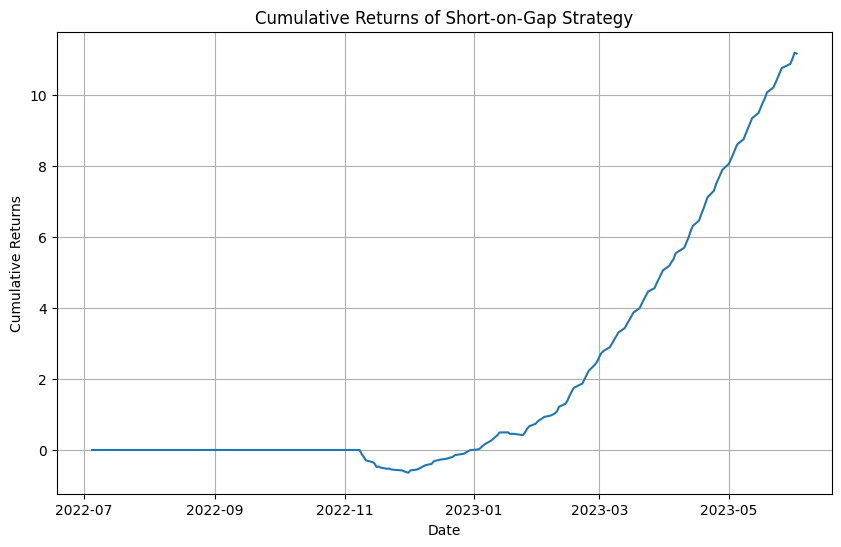

In [6]:
portfolio_returns['Cumulative_Return'] = portfolio_returns['Total_Return'].cumsum()

# APR
trading_periods = len(portfolio_returns)
years = trading_periods / 1638  
APR = (portfolio_returns['Cumulative_Return'].iloc[-1] + 1) ** (1/years) - 1

# Sharpe
mean_daily_return = portfolio_returns['Total_Return'].mean()
std_dev_return = portfolio_returns['Total_Return'].std()
sharpe_ratio = np.sqrt(1638) * (mean_daily_return / std_dev_return)

print(f"APR: {APR*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

portfolio_returns['Cumulative_Return'].plot(figsize=(10, 6), title="Cumulative Returns of Short-on-Gap Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()